# COVID 19: Forecasting using ARIMA and LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%load_ext nb_black

<IPython.core.display.Javascript object>

## Data Sources

In [2]:
confirmed_df = pd.read_csv("data/confirmed_df.csv", parse_dates=["Date"])
deaths_df = pd.read_csv("data/deaths_df.csv", parse_dates=["Date"])
recovered_df = pd.read_csv("data/recovered_df.csv", parse_dates=["Date"])

<IPython.core.display.Javascript object>

In [3]:
# Dropping Serial Number
confirmed_df.drop(["SNo"], axis=1, inplace=True)
deaths_df.drop(["SNo"], axis=1, inplace=True)
recovered_df.drop(["SNo"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [4]:
confirmed_df.head()

,Date,Province/State,Country,Confirmed
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,1.0
2,2020-01-22,Anhui,Mainland China,1.0
3,2020-01-22,Beijing,Mainland China,14.0
4,2020-01-22,Chongqing,Mainland China,6.0


<IPython.core.display.Javascript object>

In [5]:
deaths_df.head()

,Date,Province/State,Country,Deaths
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,0.0
2,2020-01-22,Anhui,Mainland China,0.0
3,2020-01-22,Beijing,Mainland China,0.0
4,2020-01-22,Chongqing,Mainland China,0.0


<IPython.core.display.Javascript object>

In [6]:
recovered_df.head()

,Date,Province/State,Country,Recovered
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,0.0
2,2020-01-22,Anhui,Mainland China,0.0
3,2020-01-22,Beijing,Mainland China,0.0
4,2020-01-22,Chongqing,Mainland China,0.0


<IPython.core.display.Javascript object>

In [7]:
confirmed_india_df = (
    confirmed_df[confirmed_df.Country == "India"]
    .groupby("Date")["Confirmed"]
    .sum()
    .sort_values(axis="index")
    .reset_index()
)

<IPython.core.display.Javascript object>

In [8]:
recovered_india_df = (
    recovered_df[recovered_df.Country == "India"]
    .groupby("Date")["Recovered"]
    .sum()
    .sort_values(axis="index")
    .reset_index()
)

<IPython.core.display.Javascript object>

In [9]:
deaths_india_df = (
    deaths_df[deaths_df.Country == "India"]
    .groupby("Date")["Deaths"]
    .sum()
    .sort_values(axis="index")
    .reset_index()
)

<IPython.core.display.Javascript object>

## LSTM

In [10]:
look_back = 1
scaler = MinMaxScaler(feature_range=(0, 1))

<IPython.core.display.Javascript object>

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

<IPython.core.display.Javascript object>

In [12]:
def normalize_split(dataset):
    # normalize the dataset
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    return trainX, trainY, testX, testY

<IPython.core.display.Javascript object>

### Confirmed (India)

In [13]:
(
    confirmed_train_X,
    confirmed_train_Y,
    confirmed_test_X,
    confirmed_test_Y,
) = normalize_split(confirmed_india_df[["Confirmed"]])

<IPython.core.display.Javascript object>

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(confirmed_train_X, confirmed_train_Y, epochs=400, batch_size=1, verbose=2)

Epoch 1/400
69/69 - 0s - loss: 0.0253
Epoch 2/400
69/69 - 0s - loss: 0.0143
Epoch 3/400
69/69 - 0s - loss: 0.0112
Epoch 4/400
69/69 - 0s - loss: 0.0101
Epoch 5/400
69/69 - 0s - loss: 0.0091
Epoch 6/400
69/69 - 0s - loss: 0.0081
Epoch 7/400
69/69 - 0s - loss: 0.0071
Epoch 8/400
69/69 - 0s - loss: 0.0061
Epoch 9/400
69/69 - 0s - loss: 0.0051
Epoch 10/400
69/69 - 0s - loss: 0.0042
Epoch 11/400
69/69 - 0s - loss: 0.0034
Epoch 12/400
69/69 - 0s - loss: 0.0026
Epoch 13/400
69/69 - 0s - loss: 0.0019
Epoch 14/400
69/69 - 0s - loss: 0.0014
Epoch 15/400
69/69 - 0s - loss: 9.6735e-04
Epoch 16/400
69/69 - 0s - loss: 6.4983e-04
Epoch 17/400
69/69 - 0s - loss: 4.1468e-04
Epoch 18/400
69/69 - 0s - loss: 2.6643e-04
Epoch 19/400
69/69 - 0s - loss: 1.6092e-04
Epoch 20/400
69/69 - 0s - loss: 1.0266e-04
Epoch 21/400
69/69 - 0s - loss: 6.6393e-05
Epoch 22/400
69/69 - 0s - loss: 5.0817e-05
Epoch 23/400
69/69 - 0s - loss: 3.9661e-05
Epoch 24/400
69/69 - 0s - loss: 3.5142e-05
Epoch 25/400
69/69 - 0s - loss: 3

<IPython.core.display.Javascript object>

In [15]:
# make predictions
confirmed_train_predict = model.predict(confirmed_train_X)
confirmed_test_predict = model.predict(confirmed_test_X)

# invert predictions
confirmed_train_predict = scaler.inverse_transform(confirmed_train_predict)
confirmed_train_Y = scaler.inverse_transform([confirmed_train_Y])
confirmed_test_predict = scaler.inverse_transform(confirmed_test_predict)
confirmed_test_Y = scaler.inverse_transform([confirmed_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(confirmed_train_Y[0], confirmed_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(
    mean_squared_error(confirmed_test_Y[0], confirmed_test_predict[:, 0])
)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 9274.13 RMSE
Test Score: 249350.63 RMSE


<IPython.core.display.Javascript object>

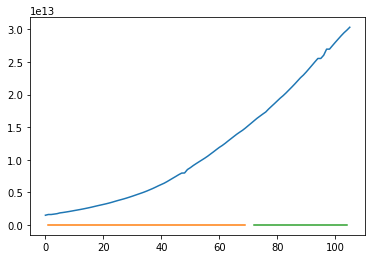

<IPython.core.display.Javascript object>

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(confirmed_india_df[["Confirmed"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(confirmed_train_predict) + look_back, :
] = confirmed_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(confirmed_india_df[["Confirmed"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(confirmed_train_predict)
    + (look_back * 2)
    + 1 : len(confirmed_india_df[["Confirmed"]])
    - 1,
    :,
] = confirmed_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(confirmed_india_df[["Confirmed"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Recovered (India)

In [17]:
(
    recovered_train_X,
    recovered_train_Y,
    recovered_test_X,
    recovered_test_Y,
) = normalize_split(recovered_india_df[["Recovered"]])

<IPython.core.display.Javascript object>

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(recovered_train_X, recovered_train_Y, epochs=400, batch_size=1, verbose=2)

Epoch 1/400
69/69 - 0s - loss: 0.0289
Epoch 2/400
69/69 - 0s - loss: 0.0181
Epoch 3/400
69/69 - 0s - loss: 0.0151
Epoch 4/400
69/69 - 0s - loss: 0.0139
Epoch 5/400
69/69 - 0s - loss: 0.0132
Epoch 6/400
69/69 - 0s - loss: 0.0125
Epoch 7/400
69/69 - 0s - loss: 0.0119
Epoch 8/400
69/69 - 0s - loss: 0.0110
Epoch 9/400
69/69 - 0s - loss: 0.0102
Epoch 10/400
69/69 - 0s - loss: 0.0096
Epoch 11/400
69/69 - 0s - loss: 0.0088
Epoch 12/400
69/69 - 0s - loss: 0.0081
Epoch 13/400
69/69 - 0s - loss: 0.0072
Epoch 14/400
69/69 - 0s - loss: 0.0065
Epoch 15/400
69/69 - 0s - loss: 0.0057
Epoch 16/400
69/69 - 0s - loss: 0.0050
Epoch 17/400
69/69 - 0s - loss: 0.0043
Epoch 18/400
69/69 - 0s - loss: 0.0036
Epoch 19/400
69/69 - 0s - loss: 0.0030
Epoch 20/400
69/69 - 0s - loss: 0.0025
Epoch 21/400
69/69 - 0s - loss: 0.0019
Epoch 22/400
69/69 - 0s - loss: 0.0015
Epoch 23/400
69/69 - 0s - loss: 0.0011
Epoch 24/400
69/69 - 0s - loss: 8.2804e-04
Epoch 25/400
69/69 - 0s - loss: 5.8045e-04
Epoch 26/400
69/69 - 0s - 

<IPython.core.display.Javascript object>

In [19]:
# make predictions
recovered_train_predict = model.predict(recovered_train_X)
recovered_test_predict = model.predict(recovered_test_X)

# invert predictions
recovered_train_predict = scaler.inverse_transform(recovered_train_predict)
recovered_train_Y = scaler.inverse_transform([recovered_train_Y])
recovered_test_predict = scaler.inverse_transform(recovered_test_predict)
recovered_test_Y = scaler.inverse_transform([recovered_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(recovered_train_Y[0], recovered_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(
    mean_squared_error(recovered_test_Y[0], recovered_test_predict[:, 0])
)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 6831.84 RMSE
Test Score: 258974.09 RMSE


<IPython.core.display.Javascript object>

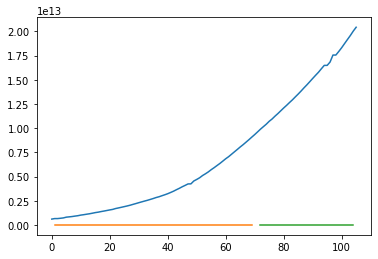

<IPython.core.display.Javascript object>

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(recovered_india_df[["Recovered"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(recovered_train_predict) + look_back, :
] = recovered_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(recovered_india_df[["Recovered"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(recovered_train_predict)
    + (look_back * 2)
    + 1 : len(recovered_india_df[["Recovered"]])
    - 1,
    :,
] = recovered_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(recovered_india_df[["Recovered"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Deaths (India)

In [21]:
(
    deaths_train_X,
    deaths_train_Y,
    deaths_test_X,
    deaths_test_Y,
) = normalize_split(deaths_india_df[["Deaths"]])

<IPython.core.display.Javascript object>

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(deaths_train_X, deaths_train_Y, epochs=400, batch_size=1, verbose=2)

Epoch 1/400
69/69 - 0s - loss: 0.0585
Epoch 2/400
69/69 - 0s - loss: 0.0331
Epoch 3/400
69/69 - 0s - loss: 0.0222
Epoch 4/400
69/69 - 0s - loss: 0.0180
Epoch 5/400
69/69 - 0s - loss: 0.0163
Epoch 6/400
69/69 - 0s - loss: 0.0150
Epoch 7/400
69/69 - 0s - loss: 0.0138
Epoch 8/400
69/69 - 0s - loss: 0.0130
Epoch 9/400
69/69 - 0s - loss: 0.0114
Epoch 10/400
69/69 - 0s - loss: 0.0102
Epoch 11/400
69/69 - 0s - loss: 0.0089
Epoch 12/400
69/69 - 0s - loss: 0.0076
Epoch 13/400
69/69 - 0s - loss: 0.0064
Epoch 14/400
69/69 - 0s - loss: 0.0052
Epoch 15/400
69/69 - 0s - loss: 0.0039
Epoch 16/400
69/69 - 0s - loss: 0.0029
Epoch 17/400
69/69 - 0s - loss: 0.0020
Epoch 18/400
69/69 - 0s - loss: 0.0013
Epoch 19/400
69/69 - 0s - loss: 7.7276e-04
Epoch 20/400
69/69 - 0s - loss: 4.5243e-04
Epoch 21/400
69/69 - 0s - loss: 2.3989e-04
Epoch 22/400
69/69 - 0s - loss: 1.2335e-04
Epoch 23/400
69/69 - 0s - loss: 6.8240e-05
Epoch 24/400
69/69 - 0s - loss: 4.5075e-05
Epoch 25/400
69/69 - 0s - loss: 3.7483e-05
Epoch 

<IPython.core.display.Javascript object>

In [23]:
# make predictions
deaths_train_predict = model.predict(deaths_train_X)
deaths_test_predict = model.predict(deaths_test_X)

# invert predictions
deaths_train_predict = scaler.inverse_transform(deaths_train_predict)
deaths_train_Y = scaler.inverse_transform([deaths_train_Y])
deaths_test_predict = scaler.inverse_transform(deaths_test_predict)
deaths_test_Y = scaler.inverse_transform([deaths_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(deaths_train_Y[0], deaths_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(
    mean_squared_error(deaths_test_Y[0], deaths_test_predict[:, 0])
)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 374.28 RMSE
Test Score: 3952.02 RMSE


<IPython.core.display.Javascript object>

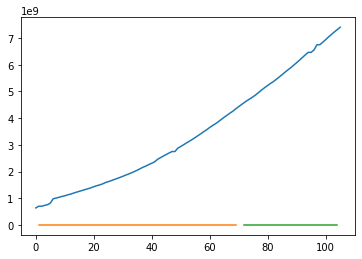

<IPython.core.display.Javascript object>

In [24]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(deaths_india_df[["Deaths"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(deaths_train_predict) + look_back, :
] = deaths_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(deaths_india_df[["Deaths"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(deaths_train_predict)
    + (look_back * 2)
    + 1 : len(deaths_india_df[["Deaths"]])
    - 1,
    :,
] = deaths_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(deaths_india_df[["Deaths"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()